# CNNs for image classification

## Step 1: Data Loading and Preprocessing

### 1.1 Import Libraries

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
import numpy as np

### Define Data Transformations

In [2]:
# Define training data augmentation and normalization
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

# Define test data normalization
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

### 1.3 Load the CIFAR-10 Dataset

In [3]:
# Download and load training data
train_dataset = torchvision.datasets.CIFAR10(
    root='./data',
    train=True,
    download=True,
    transform=transform_train
)

# Download and load test data
test_dataset = torchvision.datasets.CIFAR10(
    root='./data',
    train=False,
    download=True,
    transform=transform_test
)

Files already downloaded and verified
Files already downloaded and verified


### 1.4 Split the Data

In [4]:
# Set random seed for reproducibility
torch.manual_seed(42)

# Split train dataset into training and validation sets
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size

train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

# Create DataLoader for train, validation, and test datasets
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False, num_workers=2)

### 1.5 Verify Data Loading and Preprocessing

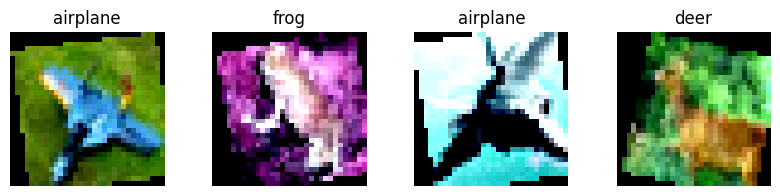

In [5]:
# Function to unnormalize, clip, and show an image
def imshow(img):
    img = img * 0.2023 + 0.4914  # Unnormalize using the mean and std deviation
    img = torch.clamp(img, 0, 1)  # Clip the values to be within [0, 1]
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)

# Define CIFAR-10 classes
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 
           'dog', 'frog', 'horse', 'ship', 'truck']

# Display images with labels
fig, axes = plt.subplots(1, 4, figsize=(10, 2))
for idx, ax in enumerate(axes):
    img = images[idx] / 2 + 0.5  # Unnormalize
    img = torch.clamp(img, 0, 1)  # Clip the values to be within [0, 1]
    npimg = img.numpy()
    ax.imshow(np.transpose(npimg, (1, 2, 0)))
    ax.set_title(classes[labels[idx]])
    ax.axis('off')
plt.show()

## Model Definition – Implementing ResNet-18

### Custom ResNet-18 Implementation

In [6]:
import torch.nn as nn
import torchvision.models as models

class CustomResNet18(nn.Module):
    def __init__(self, num_classes=10):
        super(CustomResNet18, self).__init__()
        # Load ResNet-18 architecture
        self.model = models.resnet18(pretrained=False)
        
        # Modify the initial convolution layer to fit CIFAR-10's image size
        self.model.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        
        # Remove max-pooling to avoid excessive downsampling for smaller images
        self.model.maxpool = nn.Identity()
        
        # Modify the final fully connected layer to match the number of CIFAR-10 classes
        self.model.fc = nn.Linear(self.model.fc.in_features, num_classes)
    
    def forward(self, x):
        return self.model(x)

# Instantiate the model
resnet18_model = CustomResNet18(num_classes=10)

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
resnet18_model = resnet18_model.to(device)

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


#### Define Loss Function and Optimizer

In [7]:
import torch.optim as optim

# Define loss function
criterion = nn.CrossEntropyLoss()

# Define optimizer (SGD with momentum)
optimizer = optim.SGD(resnet18_model.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)

#### Training Loop

In [8]:
num_epochs = 20  # Adjust as needed

# Training loop
for epoch in range(num_epochs):
    resnet18_model.train()  # Set model to training mode
    running_loss = 0.0
    correct = 0
    total = 0

    # Training phase
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        # Zero gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = resnet18_model(inputs)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        # Track loss and accuracy
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    # Calculate and display training accuracy
    train_acc = 100. * correct / total
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}, Accuracy: {train_acc:.2f}%")

    # Validation phase (optional)
    # You can add validation accuracy tracking here if desired

Epoch [1/20], Loss: 1.7856, Accuracy: 33.52%
Epoch [2/20], Loss: 1.3850, Accuracy: 49.81%
Epoch [3/20], Loss: 1.1527, Accuracy: 58.83%
Epoch [4/20], Loss: 0.9876, Accuracy: 65.03%
Epoch [5/20], Loss: 0.8900, Accuracy: 68.64%
Epoch [6/20], Loss: 0.8070, Accuracy: 71.77%
Epoch [7/20], Loss: 0.7495, Accuracy: 73.86%
Epoch [8/20], Loss: 0.7075, Accuracy: 75.21%
Epoch [9/20], Loss: 0.6564, Accuracy: 77.01%
Epoch [10/20], Loss: 0.6218, Accuracy: 78.36%
Epoch [11/20], Loss: 0.5941, Accuracy: 79.30%
Epoch [12/20], Loss: 0.5703, Accuracy: 80.01%
Epoch [13/20], Loss: 0.5416, Accuracy: 81.15%
Epoch [14/20], Loss: 0.5183, Accuracy: 81.86%
Epoch [15/20], Loss: 0.4950, Accuracy: 82.74%
Epoch [16/20], Loss: 0.4837, Accuracy: 83.04%
Epoch [17/20], Loss: 0.4640, Accuracy: 83.93%
Epoch [18/20], Loss: 0.4499, Accuracy: 84.28%
Epoch [19/20], Loss: 0.4341, Accuracy: 84.91%
Epoch [20/20], Loss: 0.4215, Accuracy: 85.21%


#### Adding Validation Tracking

In [9]:
# Training loop with validation phase
num_epochs = 20

for epoch in range(num_epochs):
    # Training phase
    resnet18_model.train()  # Set model to training mode
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        # Zero gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = resnet18_model(inputs)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        # Track training loss and accuracy
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    train_acc = 100. * correct / total

    # Validation phase
    resnet18_model.eval()  # Set model to evaluation mode
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():  # Disable gradient computation for validation
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = resnet18_model(inputs)
            loss = criterion(outputs, labels)

            val_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    val_acc = 100. * correct / total

    # Display results for current epoch
    print(f"Epoch [{epoch+1}/{num_epochs}], "
          f"Train Loss: {running_loss/len(train_loader):.4f}, Train Acc: {train_acc:.2f}%, "
          f"Val Loss: {val_loss/len(val_loader):.4f}, Val Acc: {val_acc:.2f}%")

Epoch [1/20], Train Loss: 0.4026, Train Acc: 86.12%, Val Loss: 0.4997, Val Acc: 82.99%
Epoch [2/20], Train Loss: 0.3980, Train Acc: 85.91%, Val Loss: 0.5192, Val Acc: 81.97%
Epoch [3/20], Train Loss: 0.3880, Train Acc: 86.49%, Val Loss: 0.4936, Val Acc: 83.03%
Epoch [4/20], Train Loss: 0.3658, Train Acc: 87.08%, Val Loss: 0.5266, Val Acc: 82.44%
Epoch [5/20], Train Loss: 0.3657, Train Acc: 87.23%, Val Loss: 0.4944, Val Acc: 82.88%
Epoch [6/20], Train Loss: 0.3515, Train Acc: 87.81%, Val Loss: 0.5312, Val Acc: 81.99%
Epoch [7/20], Train Loss: 0.3455, Train Acc: 87.90%, Val Loss: 0.4713, Val Acc: 83.88%
Epoch [8/20], Train Loss: 0.3341, Train Acc: 88.16%, Val Loss: 0.5041, Val Acc: 83.12%
Epoch [9/20], Train Loss: 0.3269, Train Acc: 88.69%, Val Loss: 0.4837, Val Acc: 83.29%
Epoch [10/20], Train Loss: 0.3168, Train Acc: 88.91%, Val Loss: 0.4615, Val Acc: 84.06%
Epoch [11/20], Train Loss: 0.3150, Train Acc: 88.94%, Val Loss: 0.4315, Val Acc: 85.15%
Epoch [12/20], Train Loss: 0.3049, Train 

### Model Evaluation on Test Set

In [10]:
# Test the model
resnet18_model.eval()  # Set model to evaluation mode
correct = 0
total = 0

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = resnet18_model(inputs)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

test_acc = 100. * correct / total
print(f"Test Accuracy: {test_acc:.2f}%")

Test Accuracy: 88.99%


## Step 2.2: AlexNet Implementation

In [14]:
import torch.nn as nn
import torch.nn.functional as F

class CustomAlexNet(nn.Module):
    def __init__(self, num_classes=10):
        super(CustomAlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),  # Adjusted kernel size and stride
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),  # Adjusted to prevent collapse

            nn.Conv2d(64, 192, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),

            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),

            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        # Adjusted classifier to handle reduced spatial dimensions
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 4 * 4, 4096),  # Adjusted for CIFAR-10 image size
            nn.ReLU(inplace=True),

            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),

            nn.Linear(4096, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)  # Flatten the feature map
        x = self.classifier(x)
        return x

# Instantiate the model
alexnet_model = CustomAlexNet(num_classes=10)

# Move model to GPU if available
alexnet_model = alexnet_model.to(device)

In [15]:
# Define loss function
criterion = nn.CrossEntropyLoss()

# Define optimizer for AlexNet (SGD with momentum)
optimizer = optim.SGD(alexnet_model.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)

In [16]:
# Training loop with validation for AlexNet
num_epochs = 20

for epoch in range(num_epochs):
    # Training phase
    alexnet_model.train()  # Set model to training mode
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        # Zero gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = alexnet_model(inputs)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        # Track training loss and accuracy
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    train_acc = 100. * correct / total

    # Validation phase
    alexnet_model.eval()  # Set model to evaluation mode
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():  # Disable gradient computation for validation
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = alexnet_model(inputs)
            loss = criterion(outputs, labels)

            val_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    val_acc = 100. * correct / total

    # Display results for current epoch
    print(f"Epoch [{epoch+1}/{num_epochs}], "
          f"Train Loss: {running_loss/len(train_loader):.4f}, Train Acc: {train_acc:.2f}%, "
          f"Val Loss: {val_loss/len(val_loader):.4f}, Val Acc: {val_acc:.2f}%")

Epoch [1/20], Train Loss: 2.2248, Train Acc: 15.43%, Val Loss: 2.0449, Val Acc: 25.09%
Epoch [2/20], Train Loss: 1.9206, Train Acc: 27.68%, Val Loss: 1.7676, Val Acc: 33.21%
Epoch [3/20], Train Loss: 1.7289, Train Acc: 35.42%, Val Loss: 1.6051, Val Acc: 40.91%
Epoch [4/20], Train Loss: 1.5907, Train Acc: 40.62%, Val Loss: 1.4863, Val Acc: 45.80%
Epoch [5/20], Train Loss: 1.4689, Train Acc: 45.73%, Val Loss: 1.3830, Val Acc: 49.33%
Epoch [6/20], Train Loss: 1.3462, Train Acc: 50.63%, Val Loss: 1.2210, Val Acc: 55.99%
Epoch [7/20], Train Loss: 1.2563, Train Acc: 54.24%, Val Loss: 1.1677, Val Acc: 57.35%
Epoch [8/20], Train Loss: 1.1721, Train Acc: 57.83%, Val Loss: 1.1778, Val Acc: 58.31%
Epoch [9/20], Train Loss: 1.1006, Train Acc: 60.20%, Val Loss: 1.0236, Val Acc: 63.01%
Epoch [10/20], Train Loss: 1.0319, Train Acc: 62.96%, Val Loss: 0.9741, Val Acc: 65.27%
Epoch [11/20], Train Loss: 0.9717, Train Acc: 65.53%, Val Loss: 0.9408, Val Acc: 66.69%
Epoch [12/20], Train Loss: 0.9405, Train 

#### Test Phase for AlexNet

In [17]:
# Test the AlexNet model
alexnet_model.eval()  # Set model to evaluation mode
correct = 0
total = 0

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = alexnet_model(inputs)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

test_acc = 100. * correct / total
print(f"Test Accuracy for AlexNet: {test_acc:.2f}%")

Test Accuracy for AlexNet: 78.21%


## 2.3: MobileNetV2 Implementation

In [18]:
class CustomMobileNetV2(nn.Module):
    def __init__(self, num_classes=10):
        super(CustomMobileNetV2, self).__init__()
        # Load MobileNetV2 with pretrained weights
        self.model = models.mobilenet_v2(pretrained=True)

        # Modify the classifier layer for CIFAR-10
        self.model.classifier[1] = nn.Linear(self.model.classifier[1].in_features, num_classes)
    
    def forward(self, x):
        return self.model(x)

# Instantiate the model
mobilenet_model = CustomMobileNetV2(num_classes=10)

# Move model to GPU if available
mobilenet_model = mobilenet_model.to(device)

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /Users/chayonimeu/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth
100%|██████████| 13.6M/13.6M [00:01<00:00, 12.8MB/s]


In [19]:
# Define loss function
criterion = nn.CrossEntropyLoss()

# Define optimizer for MobileNetV2 (SGD with momentum)
optimizer = optim.SGD(mobilenet_model.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)

In [20]:
num_epochs = 20

for epoch in range(num_epochs):
    # Training phase
    mobilenet_model.train()  # Set model to training mode
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        # Zero gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = mobilenet_model(inputs)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        # Track training loss and accuracy
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    train_acc = 100. * correct / total

    # Validation phase
    mobilenet_model.eval()  # Set model to evaluation mode
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():  # Disable gradient computation for validation
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = mobilenet_model(inputs)
            loss = criterion(outputs, labels)

            val_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    val_acc = 100. * correct / total

    # Display results for current epoch
    print(f"Epoch [{epoch+1}/{num_epochs}], "
          f"Train Loss: {running_loss/len(train_loader):.4f}, Train Acc: {train_acc:.2f}%, "
          f"Val Loss: {val_loss/len(val_loader):.4f}, Val Acc: {val_acc:.2f}%")

Epoch [1/20], Train Loss: 1.5022, Train Acc: 47.02%, Val Loss: 1.2025, Val Acc: 56.61%
Epoch [2/20], Train Loss: 1.1125, Train Acc: 61.12%, Val Loss: 1.0168, Val Acc: 63.97%
Epoch [3/20], Train Loss: 0.9959, Train Acc: 65.20%, Val Loss: 1.0140, Val Acc: 64.10%
Epoch [4/20], Train Loss: 0.9392, Train Acc: 67.58%, Val Loss: 0.8851, Val Acc: 68.90%
Epoch [5/20], Train Loss: 0.8670, Train Acc: 69.88%, Val Loss: 0.8363, Val Acc: 70.72%
Epoch [6/20], Train Loss: 0.8303, Train Acc: 71.27%, Val Loss: 0.8308, Val Acc: 70.67%
Epoch [7/20], Train Loss: 0.7914, Train Acc: 72.36%, Val Loss: 0.8094, Val Acc: 71.29%
Epoch [8/20], Train Loss: 0.8069, Train Acc: 71.92%, Val Loss: 0.7506, Val Acc: 73.59%
Epoch [9/20], Train Loss: 0.7536, Train Acc: 73.83%, Val Loss: 0.7615, Val Acc: 73.47%
Epoch [10/20], Train Loss: 0.7669, Train Acc: 73.42%, Val Loss: 0.7850, Val Acc: 72.60%
Epoch [11/20], Train Loss: 0.7346, Train Acc: 74.61%, Val Loss: 0.7345, Val Acc: 74.12%
Epoch [12/20], Train Loss: 0.7087, Train 

In [21]:
# Test the MobileNetV2 model
mobilenet_model.eval()  # Set model to evaluation mode
correct = 0
total = 0

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = mobilenet_model(inputs)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

test_acc = 100. * correct / total
print(f"Test Accuracy for MobileNetV2: {test_acc:.2f}%")

Test Accuracy for MobileNetV2: 63.44%


In [22]:
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3, verbose=True)

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [1]:
# Initialize lists to store results for each epoch
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

# After each epoch in the training loop, append losses and accuracies
train_losses.append(running_loss / len(train_loader))
val_losses.append(val_loss / len(val_loader))
train_accuracies.append(train_acc)
val_accuracies.append(val_acc)

# Plotting
import matplotlib.pyplot as plt

# Loss Curve
plt.figure(figsize=(10,5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

# Accuracy Curve
plt.figure(figsize=(10,5))
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.show()

NameError: name 'running_loss' is not defined

### Citation
Will Cukierski. CIFAR-10 - Object Recognition in Images. https://kaggle.com/competitions/cifar-10, 2013. Kaggle.